Imports

In [1]:
!git clone https://github.com/mechachki/brainet.git

Cloning into 'brainet'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 60 (delta 27), reused 42 (delta 12), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [2]:
%cd brainet

/content/brainet


In [3]:
import pymc as pm
import aesara.tensor as at
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform

from NetworkModel import *
from NetworkPrior import *
from NetworkLikelihood import *
from util import *

In [4]:
plt.rc('axes', titlesize=24)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.rc('legend', fontsize=24)  # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title

Some helper functions.

Core of framework: different network priors and the main functionality: 

* Sampling from the prior predictive distribution.
* Inference.
* Sampling from the posterior predictive distribution [TODO].
* Bayesian model comparison [TODO].

Sample from Erdös-Renýi:

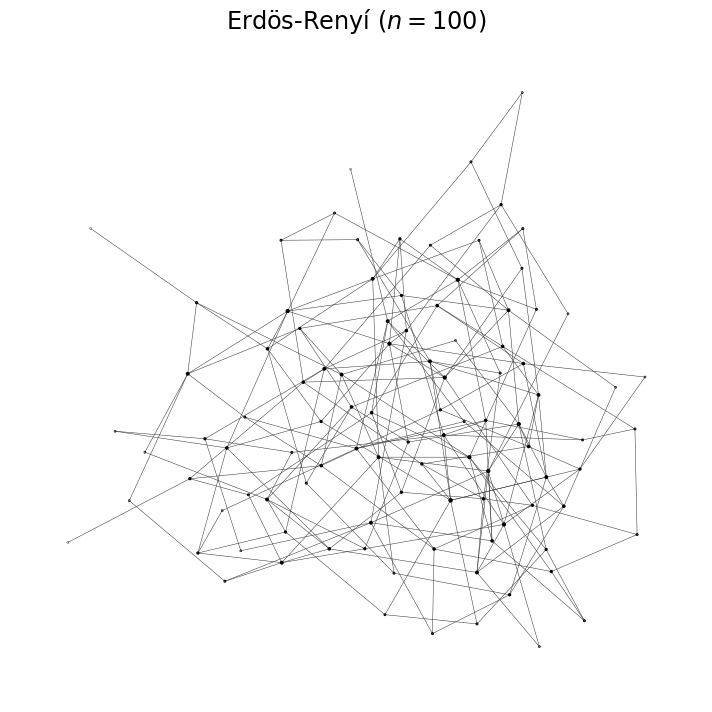

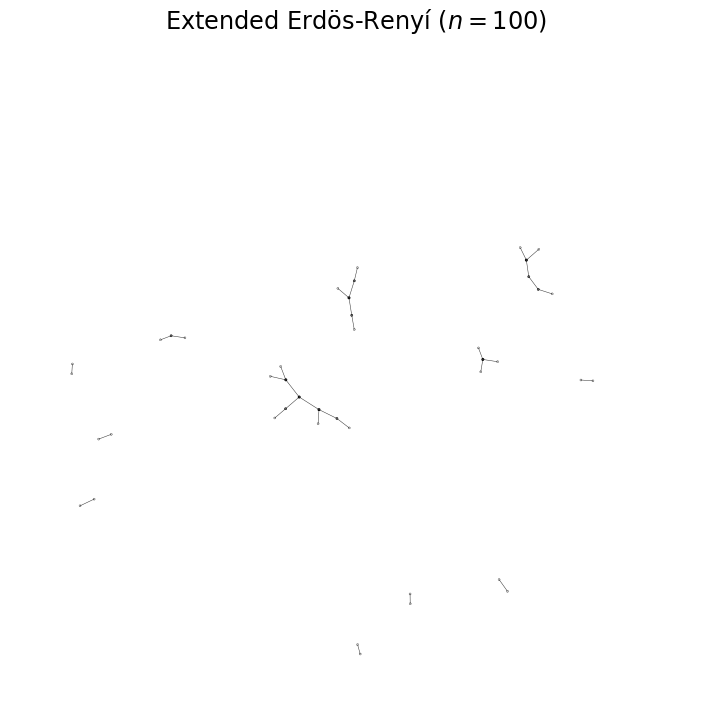

In [5]:
n = 100
er_model = NetworkModel(prior=ErdosRenyi(n=n, a=1, b=10))

er_network = er_model.sample_from_prior(num_samples=1)
plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_network(er_network, ax=ax, title=r'{:s} ($n={:d}$)'.format(er_model.prior.name, n))
plt.tight_layout()
plt.show()

n = 100
eer_model = NetworkModel(prior=ExtendedErdosRenyi(n=n, a=1, b=10))

eer_network = eer_model.sample_from_prior(num_samples=1)
plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_network(eer_network, ax=ax, title=r'{:s} ($n={:d}$)'.format(eer_model.prior.name, n))
plt.tight_layout()
plt.show()

Sample from Euclidean LSM:

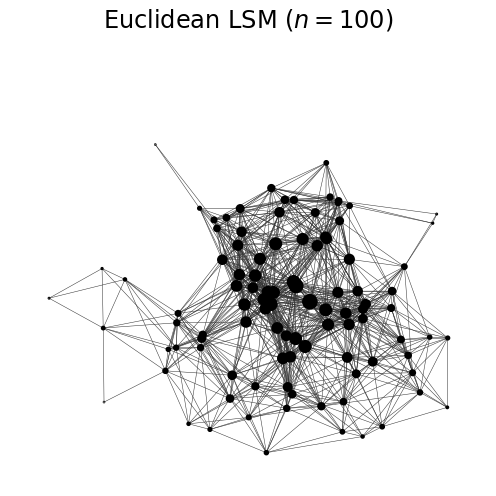

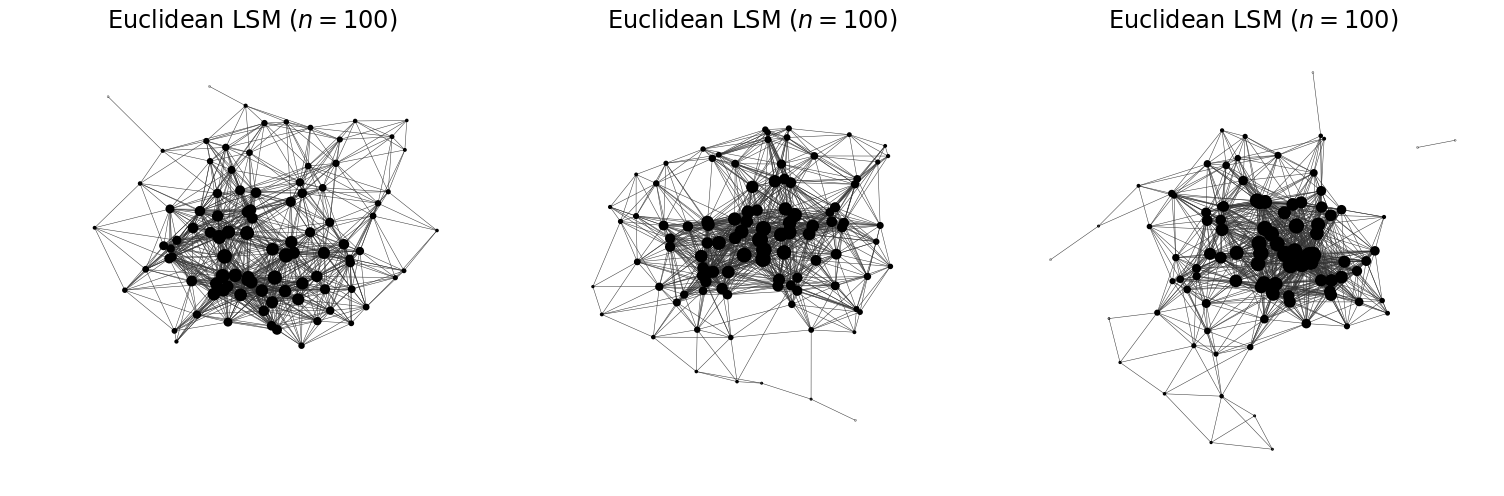

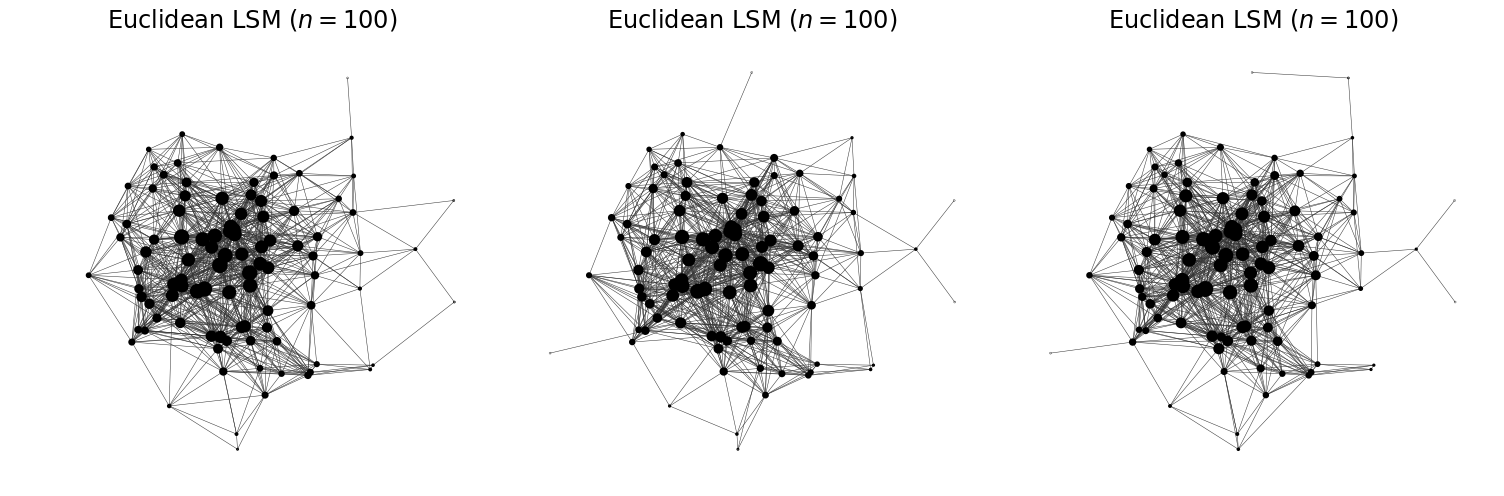

In [6]:
fig_dim = 7

n = 100
D = 2
x0 = 1
T = 0.1

# sample once from prior predictive distribution (PPD)
elsm_model = NetworkModel(prior=EuclideanLatentSpace(n=n, D=D, x0=x0, T=T))
elsm_network = elsm_model.sample_from_prior(num_samples=1)
plt.figure(figsize=(fig_dim, fig_dim))
ax = plt.gca()
plot_network(elsm_network, ax=ax, title=r'{:s} ($n={:d}$)'.format(elsm_model.prior.name, n))
plt.tight_layout()
plt.show()

### sample completely different samples from the PPD
elsm_model = NetworkModel(prior=EuclideanLatentSpace(n=n, D=D, x0=x0, T=T))
num_samples = 3
elsm_networks = elsm_model.sample_from_prior(num_samples=num_samples)
_, axes = plt.subplots(nrows=1, ncols=num_samples, sharex=True, sharey=True, figsize=(num_samples*fig_dim, fig_dim))
for i, ax in enumerate(axes):
    plot_network(elsm_networks[i], ax=ax, title=r'{:s} ($n={:d}$)'.format(elsm_model.prior.name, n))
plt.tight_layout()
plt.show()

### sample multiple instances from same latent variables
num_samples = 1
num_instances = 3
elsm_model = NetworkModel(prior=EuclideanLatentSpace(n=n, D=D, x0=x0, T=T))
elsm_networks = elsm_model.sample_from_prior(num_samples=1, num_instances=num_instances)
_, axes = plt.subplots(nrows=1, ncols=num_instances, sharex=True, sharey=True, figsize=(num_instances*fig_dim, fig_dim))
for i, ax in enumerate(axes):
    plot_network(elsm_networks[i], ax=ax, title=r'{:s} ($n={:d}$)'.format(elsm_model.prior.name, n))
plt.tight_layout()
plt.show()

Sample from hyperbolic LSM.

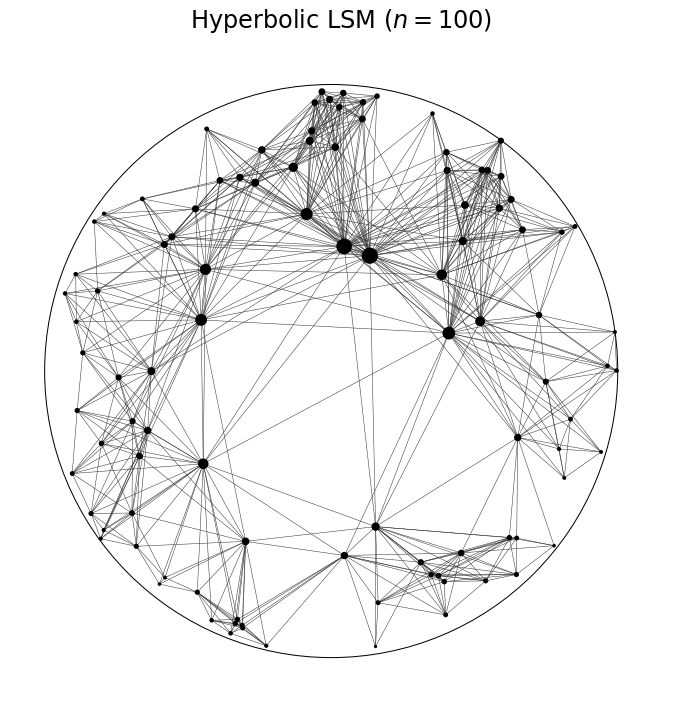

In [7]:
n = 100
R = 5
alpha = 1
T = 0.01
hlsm_model = NetworkModel(prior=HyperbolicLatentSpace(n=n, R=R, alpha=alpha, x0=x0, T=T))

hlsm_network = hlsm_model.sample_from_prior(num_samples=1)
plt.figure(figsize=(10, 10))
ax = plt.gca()
plot_network(hlsm_network, ax=ax, title=r'{:s} ($n={:d}$)'.format(hlsm_model.prior.name, n))
poincare_disk = plt.Circle((0, 0), R, color='k', fill=False, clip_on=False)
ax.add_patch(poincare_disk)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

Inference.

In [8]:
n = 50
D = 2
x0 = 1
T = 0.1

# sample once from prior predictive distribution (PPD)
elsm_model_prior = NetworkModel(prior=EuclideanLatentSpace(n=n, D=D, x0=x0, T=T))
elsm_network = elsm_model_prior.sample_from_prior(num_samples=1)

# Once we've added a likelihood to a PyMC model to sample from the PPD, we 
# cannot use the same likelihood again because the variable name is taken. 
# Easiest fix is to just instantiate a new model, as it seems impossible to 
# remove PyMC random variables from a model.

elsm_model_posterior = NetworkModel(prior=EuclideanLatentSpace(n=n, D=D, x0=x0, T=T))
trace = elsm_model_posterior.inference(elsm_network)

Show samples from posterior.

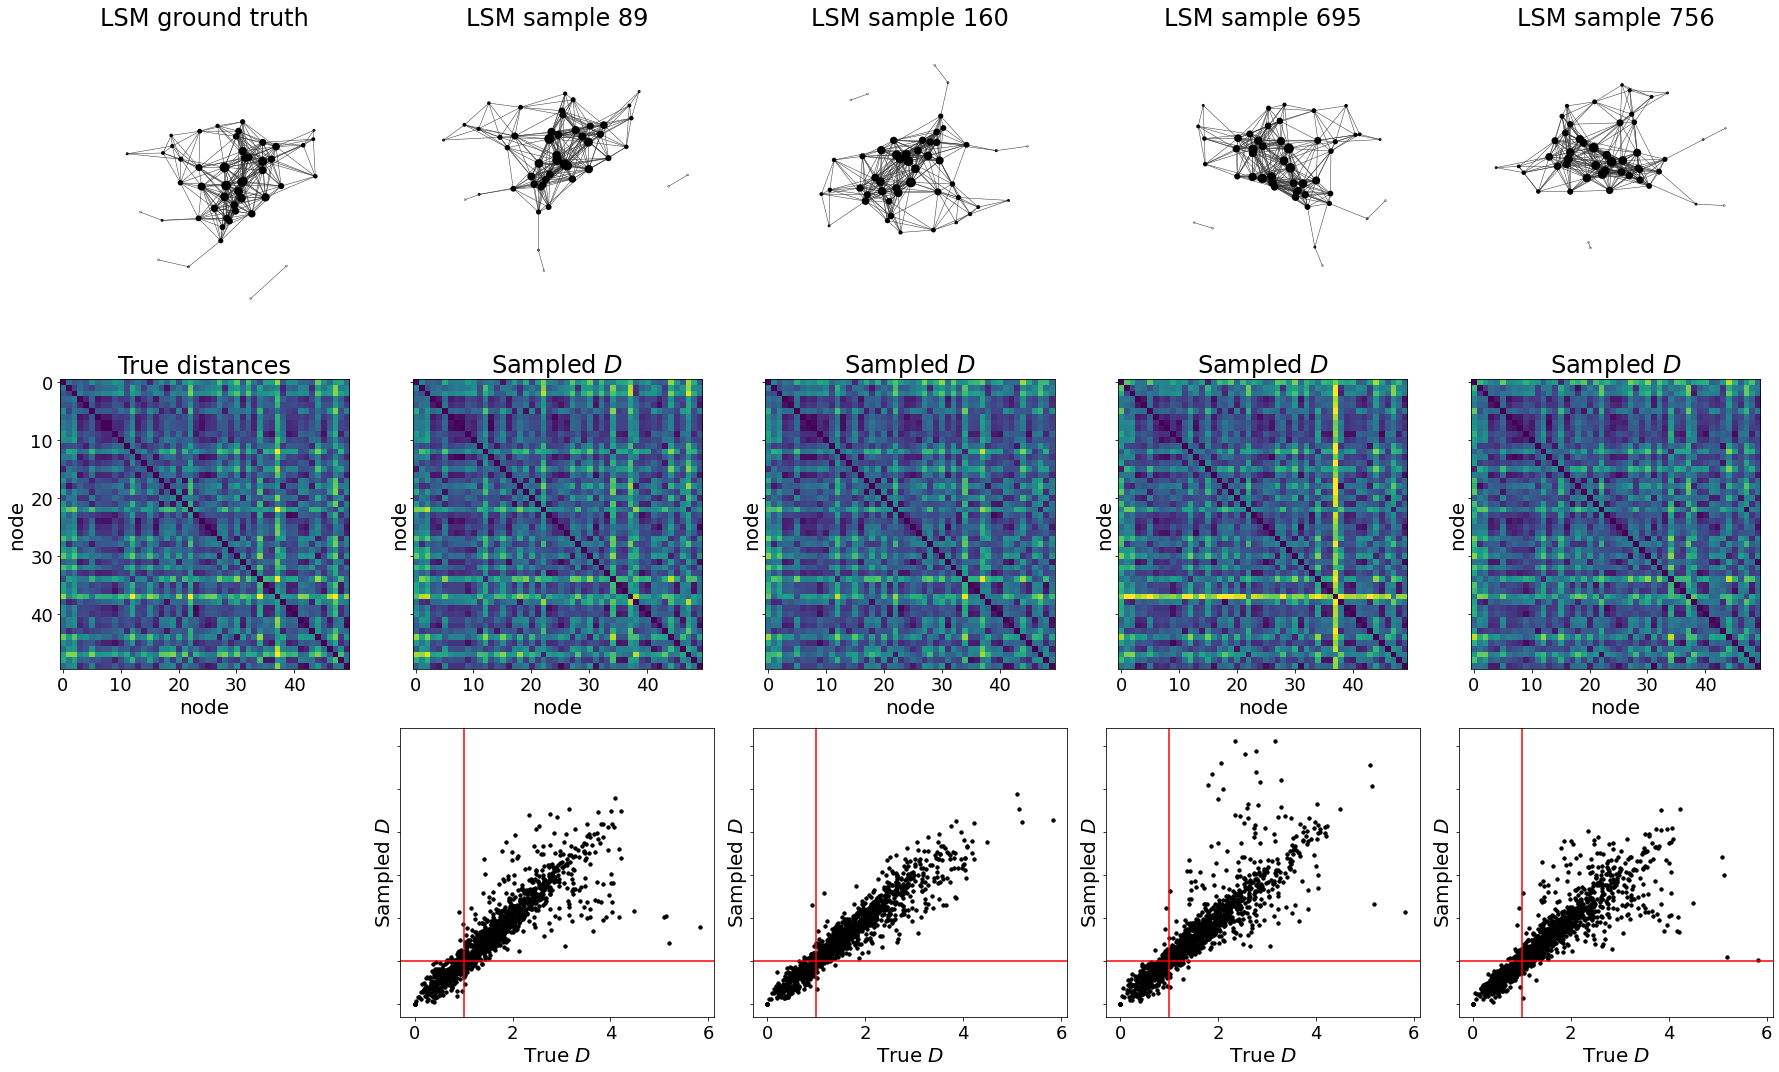

In [11]:
num_chains, num_draws, n, D = trace.posterior['z'].data.shape

# Reshape the samples of z in the trace into a [num_samples x num_nodes x num_latent_dimensions] object
samples_z = np.reshape(trace.posterior['z'].data, newshape=[num_chains*num_draws, n, D])
num_samples = samples_z.shape[0]

# Show 4 random samples
num_show = 4
ix = np.sort(np.random.randint(num_samples, size=4))

# Compute the ground truth distance matrix from the ground truth positions
z0 = nx.get_node_attributes(elsm_network, 'pos')
d0 = squareform(pdist(node_pos_dict2array(z0, n, D)))

size = 5
fig, axes = plt.subplots(nrows=3, ncols=num_show+1, 
                         figsize=(size*(num_show+1), 3*size), 
                         sharex='row', sharey='row')
plot_network(elsm_network, ax=axes[0,0], title=r'LSM ground truth'.format(n, D))

axes[1,0].imshow(d0, vmin=0, vmax=5)
axes[1,0].set_title('True distances')

for i, sample_ix in enumerate(ix):
    z_i = samples_z[sample_ix, :, :]
    node_attr_dict = {j: z_i[j, :] for j in range(n)}
    plot_network(elsm_network, pos=node_attr_dict, ax=axes[0,i+1], 
                    title=r'LSM sample {:d}'.format(sample_ix))

    d_i = squareform(pdist(node_pos_dict2array(z_i, n, D)))
    axes[1,i+1].imshow(d_i, vmin=0, vmax=5)
    axes[1,i+1].set_title('Sampled $D$'.format(sample_ix))
    axes[2,i+1].scatter(d0.flatten(), d_i.flatten(), c='k', marker='.')
    axes[2,i+1].set_xlabel('True $D$')
    axes[2,i+1].set_ylabel('Sampled $D$')
    axes[2,i+1].axvline(x=x0, color='r')
    axes[2,i+1].axhline(y=x0, color='r')

for ax in axes[1,:]:
    ax.set_xlabel('node')
    ax.set_ylabel('node')
axes[2,0].axis('off')
plt.tight_layout()

# todo

figure out a nice visualization showing the uncertainty in the invariant latents (e.g. $D$ or $p$).

---
# Hyperbolic LSM